## ANÁLISIS Y MEJORA DEL MODELO NO LINEAL 

En este documento se realizará un análisis del modelo no lineal desarrollado anteriormente, con el objetivo de entender cómo realiza sus predicciones, detectar posibles problemas de fuga de información y entrenar una versión reducida y optimizada del modelo. Para ello, se realizará un análisis de la importancia de las variables mediante SHAP y, posteriormente, se entrenará una nueva versión del modelo con las variables más importantes, reduciendo así la complejidad del modelo sin comprometer su rendimiento. Para la búsqueda de hiperparámetros se llevará a cabo un proceso de optimización bayesiana. 

In [1]:
import pandas as pd 
import shap 
import joblib 
import matplotlib.pyplot as plt
import numpy as np 
import json
from types import MethodType

/home/ybiku/projects/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ybiku/projects/zrive/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
/home/ybiku/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/pickle.py:1718: UserWarning: [15:54:15] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
100%|===================| 153894/

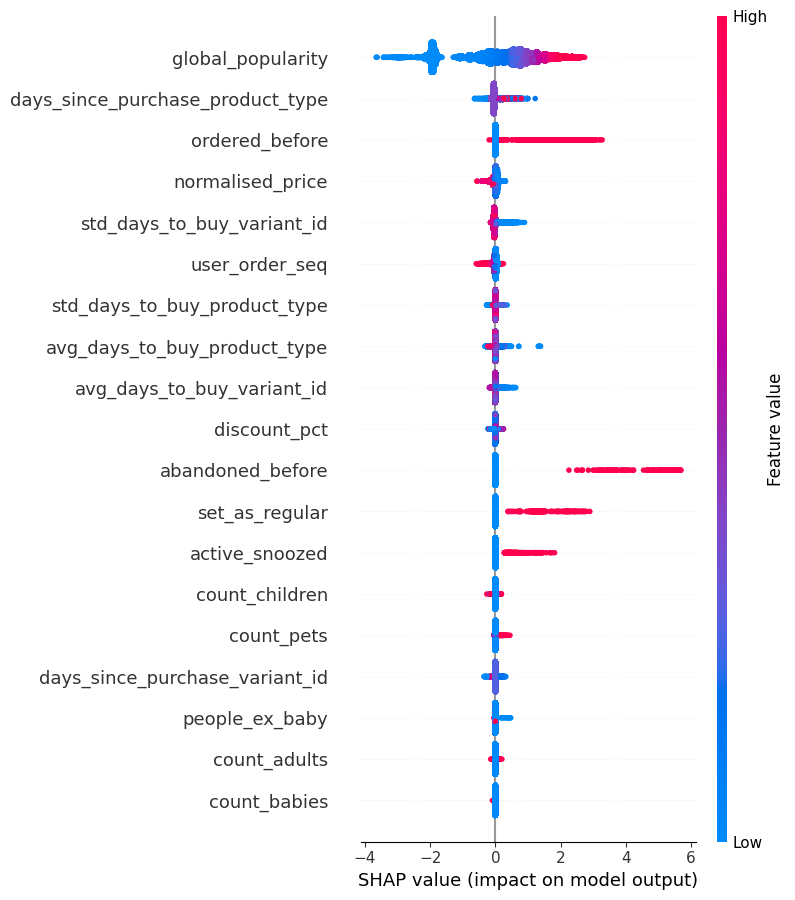

In [2]:
import importlib 
import data_processing
importlib.reload(data_processing)
from data_processing import preprocess_data_for_training 

data_path = "../data/feature_frame.csv"
data = pd.read_csv(data_path)
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_data_for_training(data)

model_path = "../models/push_2025_10_27.joblib"
pipe = joblib.load(model_path)
clf = pipe.named_steps['classifier']

n_samples = int(len(x_train) * 0.1)
class_0 = x_train[y_train == 0]
class_1 = x_train[y_train == 1]
n_class_0 = int(n_samples * (len(class_0) / len(x_train)))
n_class_1 = n_samples - n_class_0
x_train_subsample = pd.concat([class_0.sample(n_class_0, random_state=42), class_1.sample(n_class_1, random_state=42)])

explainer = shap.Explainer(clf, x_train_subsample)
shap_values = explainer(x_train_subsample)
shap.summary_plot(shap_values, x_train_subsample)

En términos absolutos de contribución, las variables más influyentes son `global_popularity`, `days_since_purchase_product_type` y `ordered_before`. Esto tiene sentido, pues si un producto es popular es más probable que se compre, y si el usuario compra de forma recurrente el producto, es probable que lo vuelva a comprar. En particular, es importante destacar el efecto que tienen las variables `ordered_before`, `abandoned_before`, `set_as_regular` y `active_snoozed`: valores negativos de estas variables no tienen influencia en el modelo, pero valores positivos empujan fuertemente la predicción hacia la clase positiva. Es decir, si el cliene ha tenido el producto en el carrito alguna vez, si lo tiene marcado como compra regular o si tiene la notificación activada, el modelo interpreta que son señales muy fuertes de que el cliente puede estar interesado en comprar el producto. Hay variables que tienen más importancia en términos absolutos que esas cuatro variables, pero su efecto en empujar la predicción hacia la clase positiva merece ser tenido en cuenta. 

#### EXPLICACIÓN DE ALTO NIVEL DEL FUNCIONAMIENTO DEL MODELO 

El algoritmo se fija principalmente en tres aspectos: **popularidad del producto**, **cuándo fue la última vez que el usuario lo compró** y **si el usuario ha comprado el producto anteriormente**. A esa información se le suma el precio del artículo y datos acerca del comportamiento de compra del usuario con ese producto y diferentes artículos del mismo tipo. Por último, el algoritmo tiene en cuenta si el usuario ha interactuado con el producto con anterioridad, mirando si lo ha abandonado en un carrito anterior, si lo tiene marcado como compra regular y si tiene las alertas activadas. Con esa información, el algoritmo determina cuál es la probabilidad de que el usuario quiera comprar el producto. 

Para tratar de simplificar el modelo, se entrenará un modelo únicamente con las siguientes variables: `global_popularity`, `ordered_before`, `abandoned_before`, `set_as_regular` y `active_snoozed`. Si el modelo reducido obtiene resultados similares, se podría reducir la complejidad del modelo sin comprometer su rendimiento. 

[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
[INFO] - create_pipeline - Creating the model pipeline...
[INFO] - fit_model - Training the model...
[INFO] - fit_model - Saving the trained model in /home/ybiku/projects/zrive/src/zrive/models...
[INFO] - fit_model - Model training and saving completed.
[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying commo

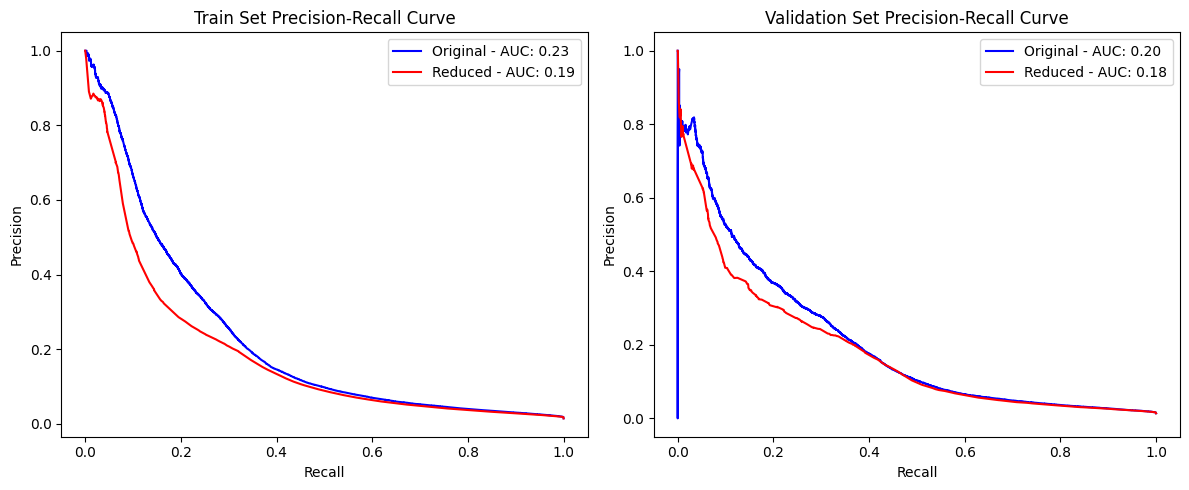

In [9]:
import train
import data_processing 
importlib.reload(data_processing)
importlib.reload(train)
from train import fit_model
from pathlib import Path
from sklearn.metrics import auc 

BASE_DIR = Path.cwd().resolve().parents[0]
DATA_PATH = BASE_DIR / "data" / "feature_frame.csv"
MODEL_PATH = BASE_DIR / "models"
RANDOM_SEED = 42

# Same hyperparameters as the original model 
model_params = {
        'n_estimators': 300,
        'eta': 0.01,
        'gamma': 5,
        'max_depth': 8
    }

columns_to_use = ['global_popularity', 'ordered_before', 'abandoned_before', 'set_as_regular', 'active_snoozed'] 
columns_to_drop = [col for col in x_train.columns if col not in columns_to_use]

original_model_path = MODEL_PATH / "original_model.joblib"
reduced_model_path = MODEL_PATH / "reduced_model.joblib"

original_model = joblib.load(original_model_path)
reduced_model = joblib.load(reduced_model_path)

_, og_recall_train, og_precision_train, og_recall_val, og_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH, 
    model_params=model_params, name='original_model', save_figure=False)

_, reduced_recall_train, reduced_precision_train, reduced_recall_val, reduced_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH,
    model_params=model_params, columns_to_drop=columns_to_drop,
    name='reduced_model', save_figure=False)

og_auc_train = auc(og_recall_train, og_precision_train)
reduced_auc_train = auc(reduced_recall_train, reduced_precision_train)
og_auc_val = auc(og_recall_val, og_precision_val)
reduced_auc_val = auc(reduced_recall_val, reduced_precision_val)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(og_recall_train, og_precision_train, label='Original - AUC: {:.2f}'.format(og_auc_train), color='blue')
plt.plot(reduced_recall_train, reduced_precision_train, label='Reduced - AUC: {:.2f}'.format(reduced_auc_train), color='red')
plt.title('Train Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(og_recall_val, og_precision_val, label='Original - AUC: {:.2f}'.format(og_auc_val), color='blue')
plt.plot(reduced_recall_val, reduced_precision_val, label='Reduced - AUC: {:.2f}'.format(reduced_auc_val), color='red')
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

Los resultados muestran que, al emplear solo las variables `global_popularity`, `ordered_before`, `abandoned_before`, `set_as_regular` y `active_snoozed`, el modelo muestra un ligero deterioro de su capacidad predictiva. A continuación, se entrenará una nueva versión del modelo con las 5 variables más importantes: `global_popularity`, `days_since_purchase_product_type`, `ordered_before`, `normalised_price` y `std_days_to_buy_variant_id`. Con esto, se podrá ver si las variables `abandoned_before`, `set_as_regular` y `active_snoozed` realmente tienen un peso significativo en las predicciones realizadas por el modelo. 

[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
[INFO] - preprocess_data_for_training - Dropping additional columns: ['user_order_seq', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'discount_pct', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type']...
[INFO] - create_pipeline - Creating the model pipeline...
[INFO] - fit_model - Training the model...
[INFO] - fit_model - Saving the trained model in /home/ybiku/projects/zrive/src/zrive/models.

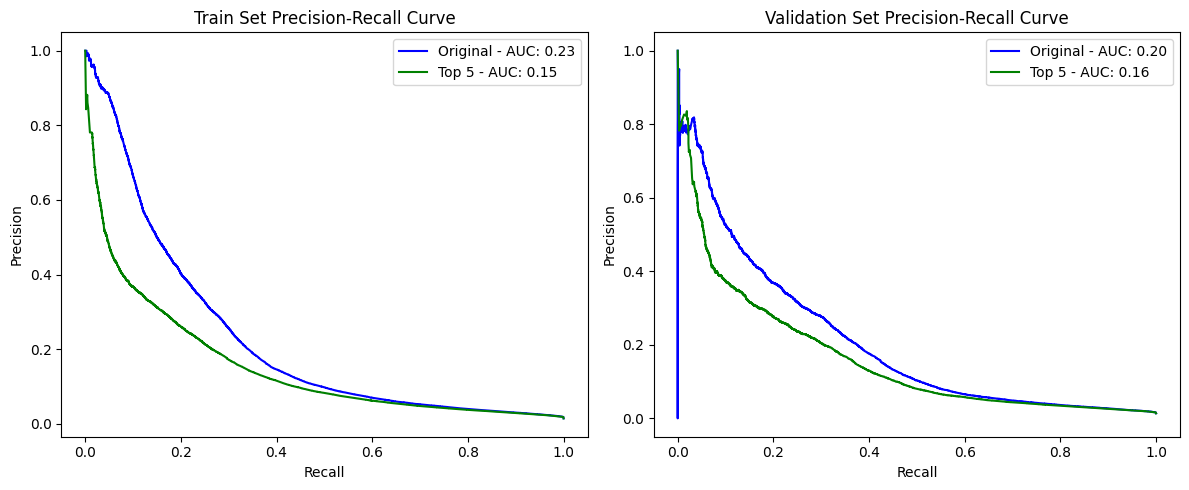

In [10]:
columns_to_use = ['global_popularity', 'days_since_purchase_product_type', 
                  'ordered_before', 'normalised_price', 'std_days_to_buy_variant_id']
columns_to_drop = [col for col in x_train.columns if col not in columns_to_use]
_, top5_recall_train, top5_precision_train, top5_recall_val, top5_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH,
    model_params=model_params, columns_to_drop=columns_to_drop,
    name='top5_model', save_figure=False)

top5_auc_train = auc(top5_recall_train, top5_precision_train)
top5_auc_val = auc(top5_recall_val, top5_precision_val)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(og_recall_train, og_precision_train, label='Original - AUC: {:.2f}'.format(og_auc_train), color='blue')
plt.plot(top5_recall_train, top5_precision_train, label='Top 5 - AUC: {:.2f}'.format(top5_auc_train), color='green')
plt.title('Train Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(og_recall_val, og_precision_val, label='Original - AUC: {:.2f}'.format(og_auc_val), color='blue')
plt.plot(top5_recall_val, top5_precision_val, label='Top 5 - AUC: {:.2f}'.format(top5_auc_val), color='green')
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

El rendimiento ha disminuido de forma considerable. Ahora se probará a entrenar el modelo con las 10 variables más influyentes según SHAP. 

[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
[INFO] - preprocess_data_for_training - Dropping additional columns: ['abandoned_before', 'active_snoozed', 'set_as_regular', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id']...
[INFO] - create_pipeline - Creating the model pipeline...
[INFO] - fit_model - Training the model...
[INFO] - fit_model - Saving the trained model in /home/ybiku/projects/zrive/src/zrive/models...
[INFO] - fit_model - Model training and saving completed.


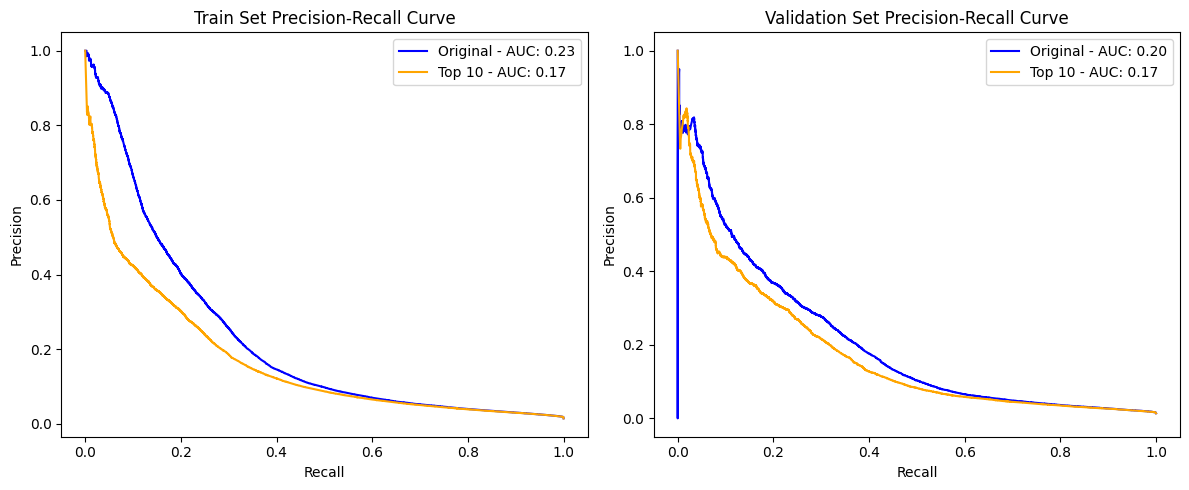

In [11]:
top10_columns = shap_values.abs.mean(0).values.argsort()[-10:][::-1]
top10_column_names = x_train.columns[top10_columns].tolist()

columns_to_drop = [col for col in x_train.columns if col not in top10_column_names]
_, top10_recall_train, top10_precision_train, top10_recall_val, top10_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH,
    model_params=model_params, columns_to_drop=columns_to_drop,
    name='top10_model', save_figure=False)

top10_auc_train = auc(top10_recall_train, top10_precision_train)
top10_auc_val = auc(top10_recall_val, top10_precision_val)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(og_recall_train, og_precision_train, label='Original - AUC: {:.2f}'.format(og_auc_train), color='blue')
plt.plot(top10_recall_train, top10_precision_train, label='Top 10 - AUC: {:.2f}'.format(top10_auc_train), color='orange')
plt.title('Train Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(og_recall_val, og_precision_val, label='Original - AUC: {:.2f}'.format(og_auc_val), color='blue')
plt.plot(top10_recall_val, top10_precision_val, label='Top 10 - AUC: {:.2f}'.format(top10_auc_val), color='orange')
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

Aun empleando las 10 variables más importantes, el modelo reducido sigue obteniendo peores resultados que el modelo original. Ahora, empleando las 13 variables más importantes: 

[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
[INFO] - preprocess_data_for_training - Dropping additional columns: ['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id']...
[INFO] - create_pipeline - Creating the model pipeline...
[INFO] - fit_model - Training the model...
[INFO] - fit_model - Saving the trained model in /home/ybiku/projects/zrive/src/zrive/models...
[INFO] - fit_model - Model training and saving completed.


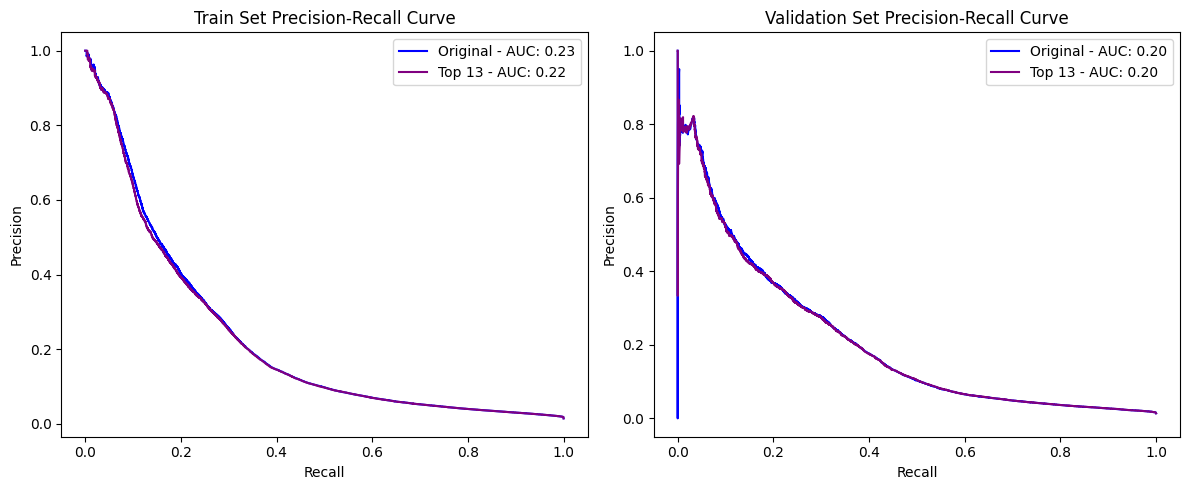

In [12]:
top13_columns = shap_values.abs.mean(0).values.argsort()[-13:][::-1]
top13_column_names = x_train.columns[top13_columns].tolist()

columns_to_drop = [col for col in x_train.columns if col not in top13_column_names]
_, top13_recall_train, top13_precision_train, top13_recall_val, top13_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH,
    model_params=model_params, columns_to_drop=columns_to_drop,
    name='top13_model', save_figure=False)

top13_auc_train = auc(top13_recall_train, top13_precision_train)
top13_auc_val = auc(top13_recall_val, top13_precision_val)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(og_recall_train, og_precision_train, label='Original - AUC: {:.2f}'.format(og_auc_train), color='blue')
plt.plot(top13_recall_train, top13_precision_train, label='Top 13 - AUC: {:.2f}'.format(top13_auc_train), color='purple')
plt.title('Train Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(og_recall_val, og_precision_val, label='Original - AUC: {:.2f}'.format(og_auc_val), color='blue')
plt.plot(top13_recall_val, top13_precision_val, label='Top 13 - AUC: {:.2f}'.format(top13_auc_val), color='purple')
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

Los resultados obtenidos con las top-13 variables son prácticamente idénticos que los del modelo original (22 variables). Esto demuestra que, aunque las variables más importantes para el modelo sean `global_popularity`, `days_since_purchase_product_type`, `ordered_before`, `normalised_price` y `std_days_to_buy_variant_id`, las variables `abandoned_before`, `set_as_regular` y `active_snoozed` sirven como apoyo para añadir un poco de poder predictivo. A este nuevo modelo se le aplicará una búsqueda de hiperparámetros para tratar de sacarle el máximo partido posible. 

In [13]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier

model_path = "../models/top13_model.joblib"
model = joblib.load(model_path)

INT_KEYS = ['classifier__n_estimators', 'classifier__max_depth', 'classifier__max_leaves',]

def xgb_evaluation_function(**params):
    for k in INT_KEYS:
        if k in params:
            params[k] = int(round(params[k]))

    model.set_params(**params)

    model.fit(x_train[top13_column_names], y_train,)
    probs = model.predict_proba(x_val[top13_column_names])[:, 1]
    return average_precision_score(y_val, probs)

bounds = {
    'classifier__n_estimators': (40, 300),
    'classifier__learning_rate': (0.01, 0.3),
    'classifier__gamma': (0, 5),
    'classifier__max_depth': (3, 10),
    'classifier__min_child_weight': (1, 10),
    'classifier__max_delta_step': (0, 10),
    'classifier__lambda': (0.01, 10.0),
    'classifier__alpha': (0.01, 10.0), 
    'classifier__scale_pos_weight': (1, 20)
} 

model_bo = BayesianOptimization(
    f=xgb_evaluation_function,
    pbounds=bounds,
    random_state=42,
    verbose=2
)

model_bo.maximize(init_points=5, n_iter=25)

|   iter    |  target   | classi... | classi... | classi... | classi... | classi... | classi... | classi... | classi... | classi... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.1929345 | 137.38043 | 0.2857071 | 3.6599697 | 7.1906093 | 2.4041677 | 1.5599452 | 0.5902552 | 8.6630996 | 12.421185 |
| 2         | 0.1995347 | 224.09887 | 0.0159695 | 4.8495492 | 8.8270984 | 2.9110519 | 1.8182496 | 1.8422110 | 3.0493800 | 10.970372 |
| 3         | 0.1971078 | 152.30570 | 0.0944564 | 3.0592644 | 3.9764570 | 3.6293018 | 3.6636184 | 4.5661391 | 7.8539078 | 4.7938018 |
| 4         | 0.1947192 | 173.70095 | 0.1818002 | 0.2322520 | 7.2528139 | 2.5347171 | 0.6505159 | 9.4893665 | 9.6566640 | 16.359549 |
| 5         | 0.2015842 | 119.19957 | 0.0383249 | 3.4211651 | 6.0810674 | 2.0983441 | 4.9517691 | 0.3535413 | 9.0941108 | 5.9168196 |
| 6         | 0.1908142 | 223.98135 | 0.2200910 | 3.5095127 | 

Las variables empleadas se pueden dividir en dos grupos: 
1. **Variables sobre el producto**: `global_popularity`, `normalised_price`, `discount_pct`. 
2. **Variables sobre el usuario**: `days_since_purchase_product_type`, `ordered_before`, `std_days_to_buy_variant_id`, `user_order_seq`, `std_days_to_buy_product_type`, `avg_days_to_buy_product_type`, `avg_days_to_buy_variant_id`, `abandoned_before`, `set_as_regular`, `active_snoozed`. 

[INFO] - fit_model - Loading data...
[INFO] - fit_model - Preprocessing data...
[INFO] - preprocess_data_for_training - Filtering orders with at least 5 items...
[INFO] - preprocess_data_for_training - Splitting data into train, validation, and test sets...
[INFO] - preprocess_data_for_training - Applying common transformations...
[INFO] - preprocess_data_for_training - Dropping categorical columns: ['product_type', 'vendor']...
[INFO] - preprocess_data_for_training - Dropping additional columns: ['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id']...
[INFO] - create_pipeline - Creating the model pipeline...
[INFO] - fit_model - Training the model...
[INFO] - fit_model - Saving the trained model in /home/ybiku/projects/zrive/src/zrive/models...
[INFO] - fit_model - Model training and saving completed.


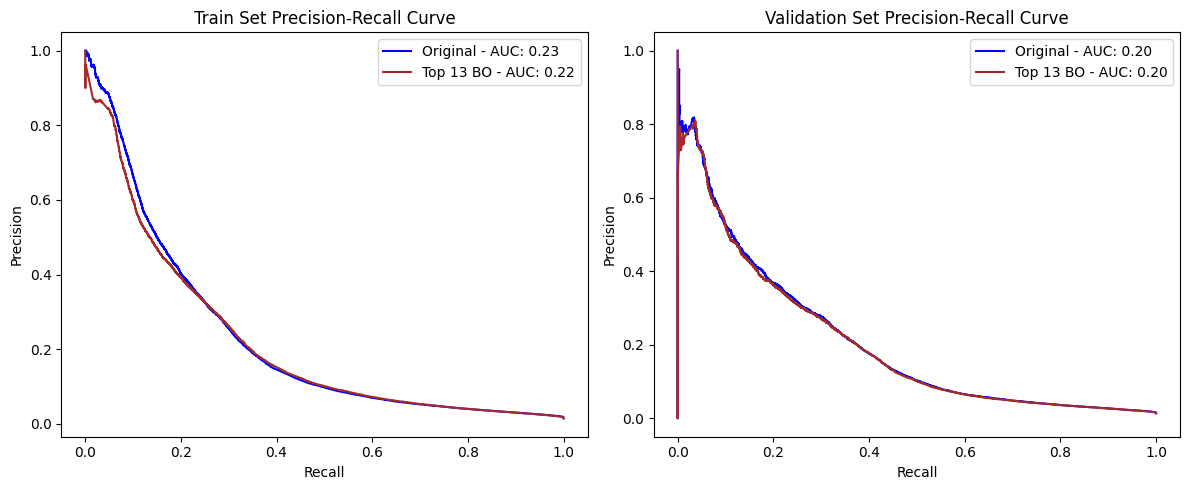

In [14]:
best_params = model_bo.max['params']
for k in INT_KEYS:
    if k in best_params:
        best_params[k] = int(round(best_params[k]))

cleaned_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}

_, bo_recall_train, bo_precision_train, bo_recall_val, bo_precision_val = train.fit_model(
    data_path=DATA_PATH, model_path=MODEL_PATH,
    model_params=cleaned_params, columns_to_drop=[col for col in x_train.columns if col not in top13_column_names],
    name='top13_bo_model', save_figure=False)

bo_auc_train = auc(bo_recall_train, bo_precision_train)
bo_auc_val = auc(bo_recall_val, bo_precision_val)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(og_recall_train, og_precision_train, label='Original - AUC: {:.2f}'.format(og_auc_train), color='blue')
plt.plot(bo_recall_train, bo_precision_train, label='Top 13 BO - AUC: {:.2f}'.format(bo_auc_train), color='brown')
plt.title('Train Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(og_recall_val, og_precision_val, label='Original - AUC: {:.2f}'.format(og_auc_val), color='blue')
plt.plot(bo_recall_val, bo_precision_val, label='Top 13 BO - AUC: {:.2f}'.format(bo_auc_val), color='brown')
plt.title('Validation Set Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

Los resultados son prácticamente iguales, por lo que se ha conseguido reducir la complejidad del modelo sin comprometer su rendimiento. 

100%|===================| 153839/153981 [01:30<00:00]        

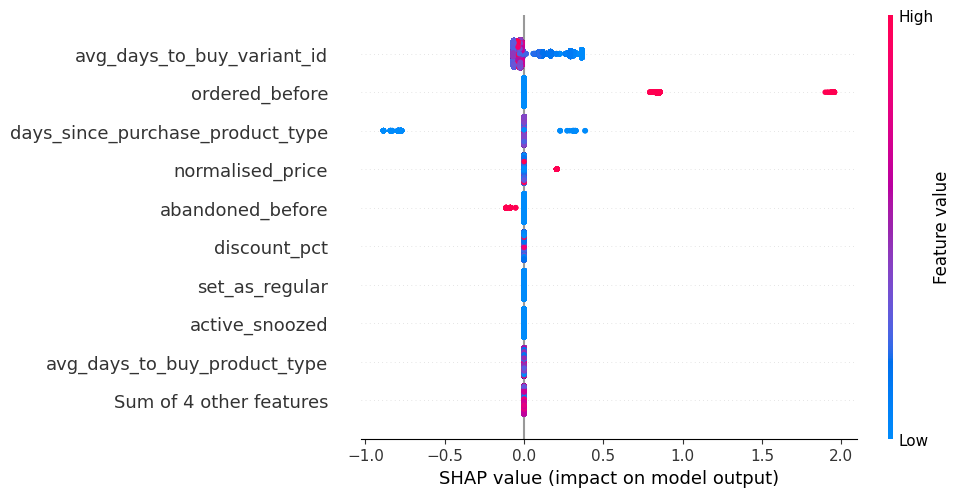

In [15]:
n_samples = int(len(x_train) * 0.1)
class_0 = x_train[y_train == 0]
class_1 = x_train[y_train == 1]
n_class_0 = int(n_samples * (len(class_0) / len(x_train)))
n_class_1 = n_samples - n_class_0
x_train_subsample = pd.concat([class_0.sample(n_class_0, random_state=42), class_1.sample(n_class_1, random_state=42)])
model_path = "../models/top13_bo_model.joblib"
model = joblib.load(model_path)
explainer = shap.Explainer(model.named_steps['classifier'], x_train_subsample[top13_column_names])
shap_values = explainer(x_train_subsample[top13_column_names])
shap.plots.beeswarm(shap_values)

De este gráfico se puede extraer información de cómo emplea el modelo las variables: 

- `avg_days_to_buy_variant_id` se muestra como la variable más importante, pero no parece tener una relación clara con la variable objetivo. Valores más pequeños (esto es, si el producto es comprado muy frecuentemente) empuja un poco la predicción hacia la clase positiva. Sin embargo, la falta de relación clara entre valor de la variable y output puede sugerir que su influencia no es lineal, sino que viene dada en formas no lineales o en combinación con otras variables. 
- En cuanto a `ordered_before`, se ve que valores positivos de esta variable empujan la predicción hacia la clase positiva, lo que muestra que si el usuario ha comprado antes el producto, el modelo interpreta que es probable que lo vuelva a comprar. 
- Para `days_since_purchase_product_type`, cuanto más reciente sea la última compra realizada, menor es la probabilidad de que el usuario vuelva a comprar el producto (parece lógico, pues si lo ha comprado recientemente no va a necesitar comprarlo ahora). 
- El resto de variables no parecen mostrar una relación evidente, por lo que su influencia vendrá dada por relaciones no lineales o combinaciones entre ellas. 

En definitiva, el modelo toma el promedio de días que el usuario tarda en comprar el producto como variable más importante, seguido de si el usuario ha comprado el producto anteriormente. El resto de variables complementan la información. 

Algo a destacar es que este nuevo modelo reducido no emplea las variables de la misma forma que el modelo original. En el original, las variables `abandoned_before`, `set_as_regular` y `active_snoozed` presentaban una influencia clara: valores positivos empujaban la predicción hacia la clase positiva. Sin embargo, en este nuevo modelo no ocurre lo mismo. En general, la importancia de las variables es menos clara e interpretable que en el modelo original, lo que desde una perspectiva de negocio podría llevar a que se deposite menos confianza en él, pese a que sea computacionalmente menos costoso y no reduzca el rendimiento de la herramienta. De cara a una presentación de resultados, habría que plantear esta cuestión para decidir qué modelo escoger, el original (más interpretable) o el reducido (más optimizado). 